# Importing Libraries

In [1]:
import cv2
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.callbacks import Callback , ReduceLROnPlateau , ModelCheckpoint, CSVLogger
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tensorflow.keras.losses import categorical_crossentropy as logloss
from tensorflow.keras.metrics import categorical_accuracy
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
import scipy
import tensorflow as tf
from sklearn import metrics
from sklearn.model_selection import train_test_split
import json

# Reading Data:

In [2]:
base_path='/kaggle/input/deepfake-and-real-images/Dataset/'

In [3]:
def plot_img(base_path, set_):
    dir_ = os.path.join(base_path, 'Train', set_)
    k = 0
    fig, ax = plt.subplots(3,3, figsize=(10,10))
    fig.suptitle(set_ + 'Faces')
    for j in range(3):
        for i in range(3):
            img = load_img(os.path.join(dir_, os.listdir(os.path.join(dir_))[k]))          
            ax[j,i].imshow(img)
            ax[j,i].set_title("")
            ax[j,i].axis('off')
            k +=1
  #  fig.tight_layout()
    plt.suptitle(set_ + ' Faces')
    return plt

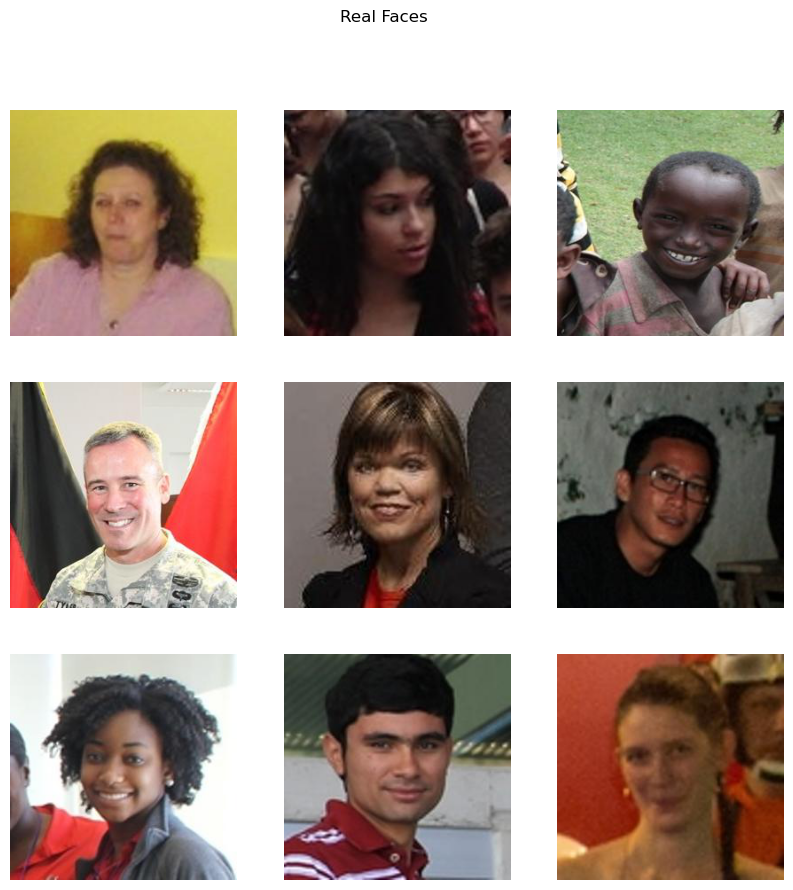

In [4]:
plot_img(base_path, 'Real').show()

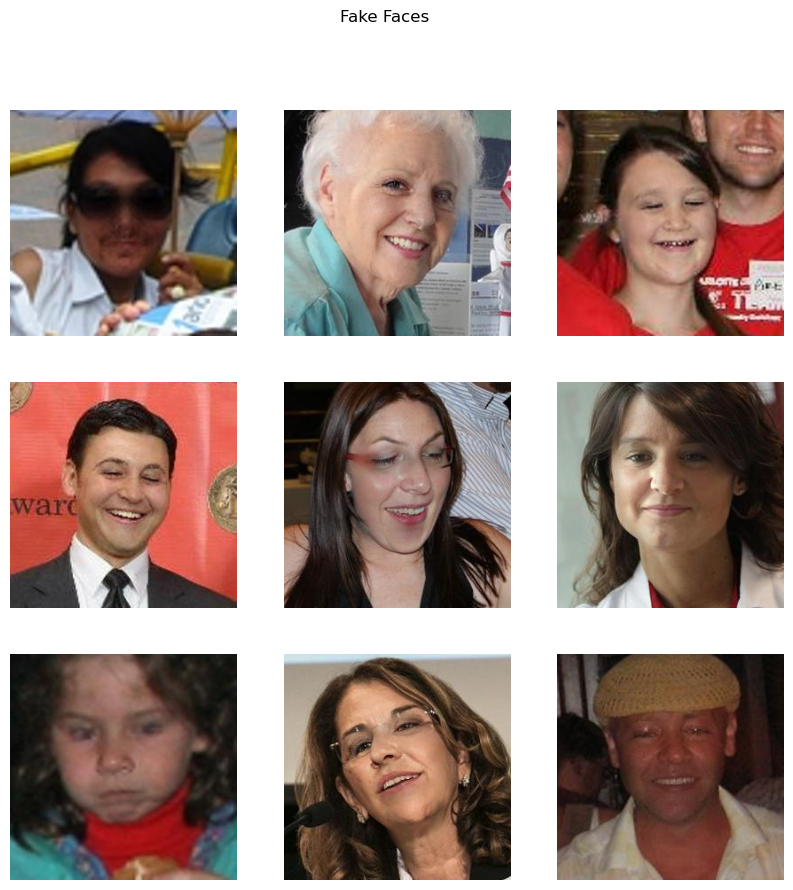

In [5]:
plot_img(base_path, 'Fake').show()

In [6]:
ig = ImageDataGenerator(rescale=1./255.)
train_flow = ig.flow_from_directory(
    base_path + 'Train/',
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical'
)

ig1 = ImageDataGenerator(rescale=1./255.)
valid_flow = ig1.flow_from_directory(
    base_path + 'Validation/',
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical'
)

test_flow = ig.flow_from_directory(
    base_path + 'Test/',
    target_size=(128, 128),
    batch_size=1,
    shuffle = False,
    class_mode='categorical'
)

train_flow.class_indices

Found 140002 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.


{'Fake': 0, 'Real': 1}

# Creating Model, ResNet-50 :

In [7]:
input_shape=(128,128,3)
batch_size=64


def build_model():
    densenet = ResNet50(
                        weights='imagenet',
                        include_top=False,
                        input_shape=input_shape
                        )
    model = Sequential([densenet,
                        layers.GlobalAveragePooling2D(),
                        layers.Dense(512,activation='relu'),
                        layers.BatchNormalization(),
                        layers.Dense(2, activation='softmax')
                        ])
    model.compile(optimizer=Adam(lr=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy']
                 )
    return model


model = build_model()
model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                         

In [9]:
from sklearn.metrics import confusion_matrix
import tensorflow as tf

class PredictionCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(valid_flow[0][0])
        y_test = valid_flow[0][1]
        y_pred_labels = np.argmax(y_pred, axis=1)
        y_test_labels = np.argmax(y_test, axis=1)
        print(y_pred_labels.shape)
        print(y_test_labels.shape)
        cfm = confusion_matrix(y_test_labels, y_pred_labels)
        print(cfm)
        print(y_pred[0], y_test[0])

In [10]:
train_steps = 140002//batch_size
valid_steps = 10000//batch_size

history = model.fit(train_flow,
    epochs = 10,
    steps_per_epoch =train_steps,
    validation_data =valid_flow,
    validation_steps = valid_steps,
    callbacks=[PredictionCallback()]
)

Epoch 1/10
2/2 [==============================] - 2s 13ms/steps - loss: 0.1190 - accuracy: 0.95
(64,)
(64,)
[[27  1]
 [ 8 28]]
[9.5916685e-04 9.9904078e-01] [0. 1.]
2187/2187 [==============================] - 875s 381ms/step - loss: 0.1190 - accuracy: 0.9537 - val_loss: 0.2351 - val_accuracy: 0.9156
Epoch 2/10
2/2 [==============================] - 0s 23ms/steps - loss: 0.0774 - accuracy: 0.96
(64,)
(64,)
[[32  1]
 [ 4 27]]
[5.675009e-04 9.994325e-01] [0. 1.]
2187/2187 [==============================] - 421s 192ms/step - loss: 0.0774 - accuracy: 0.9699 - val_loss: 0.1889 - val_accuracy: 0.9349
Epoch 3/10
2/2 [==============================] - 0s 25ms/steps - loss: 0.0652 - accuracy: 0.97
(64,)
(64,)
[[28  1]
 [ 8 27]]
[9.999443e-01 5.568692e-05] [1. 0.]
2187/2187 [==============================] - 413s 189ms/step - loss: 0.0652 - accuracy: 0.9744 - val_loss: 0.2844 - val_accuracy: 0.8761
Epoch 4/10
2/2 [==============================] - 0s 24ms/steps - loss: 0.0594 - accuracy: 0.97
(6

# Saving the Model:

In [12]:
model.save("Resnet_50.h5")

# Plotting Accuracy and Loss Graph

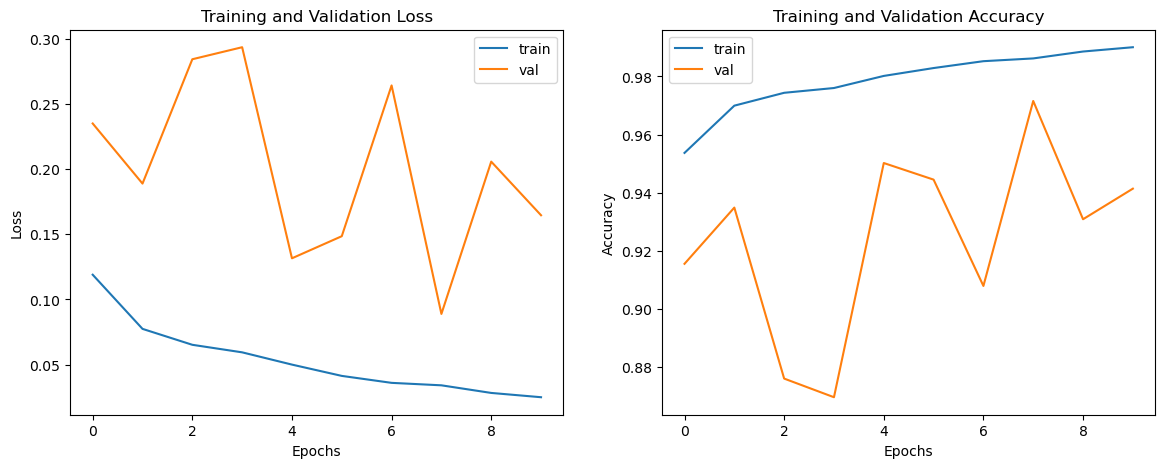

In [13]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

# Confusion Matrix:

In [14]:
y_pred = model.predict(test_flow)

y_test = test_flow.classes

10905/10905 [==============================] - 103s 9ms/step


In [17]:
y_pred_labels = np.argmax(y_pred, axis=1)

In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix=confusion_matrix(y_test, y_pred_labels)
confusion_matrix

array([[4963,  529],
       [1078, 4335]])

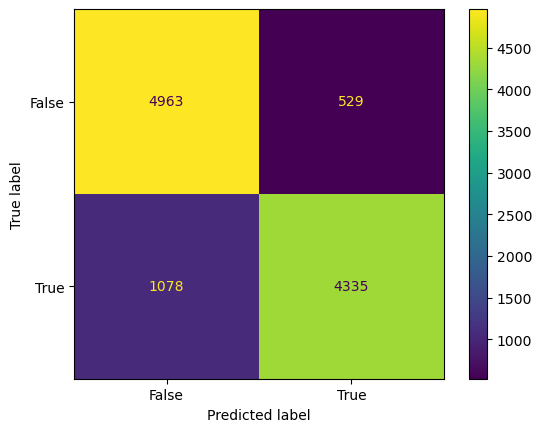

In [19]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

# ROC AUC and Precision Score:

In [20]:
from sklearn import metrics
print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred_labels))
print("AP Score:", metrics.average_precision_score(y_test, y_pred_labels))
print()
print(metrics.classification_report(y_test, y_pred_labels))

ROC AUC Score: 0.8522639416128716
AP Score: 0.8126045404996559

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      5492
           1       0.89      0.80      0.84      5413

    accuracy                           0.85     10905
   macro avg       0.86      0.85      0.85     10905
weighted avg       0.86      0.85      0.85     10905



In [21]:
_, accu = model.evaluate(test_flow)
print('Final Test Acccuracy = {:.3f}'.format(accu*100))

10905/10905 [==============================] - 112s 10ms/step - loss: 0.3955 - accuracy: 0.8526
Final Test Acccuracy = 85.264


# Testing the model on a random Image:

(1, 128, 128, 3)

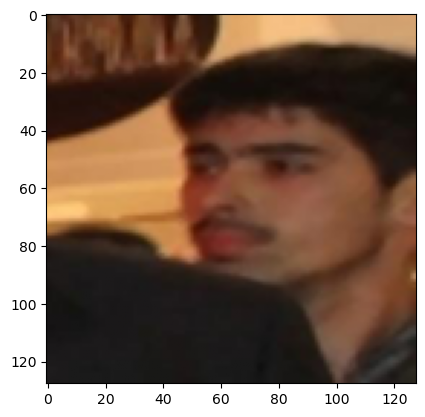

In [22]:
import PIL
from PIL import Image
im1 = Image.open('/kaggle/input/deepfake-and-real-images/Dataset/Test/Real/real_1078.jpg')
im2=im1.resize((128,128))
p1 = np.array(im2)
p1=p1/255
plt.imshow(p1)
p1 = np.expand_dims(p1, axis=0)
p1.shape

In [23]:
p=np.argmax(model.predict(p1),axis=1)
print(p)
if p==[0]:
    print('Fake Image')
else:
    print('Real Image')

1/1 [==============================] - 1s 1s/step
[1]
Real Image
